In [1]:
# General libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import sys
import os

# Chemical Data Processing
import rdkit
print(rdkit.__version__)
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from rdkit import Chem #,RDConfig
from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors, AllChem, rdqueries, Lipinski 
PandasTools.RenderImagesInAllDataFrames(images=True)
from NP_Score  import npscorer

2024.03.5


# Read in data

In [2]:
def read_sdf_to_dataframe(sdffile):
    """
    Read in molecular data from a single .sdf file

    Parameters: 
    sdffile (str):       The path and name of the SDF file.

    Returns: 
    df (pd.DataFrame):   A pandas DataFrame containing the molecular data.

    """
    # Load molecules from the SDF file, keeping explicit hydrogens!
    mols = Chem.SDMolSupplier(sdffile, removeHs=False)
    # Create a list of dictionaries using list comprehension
    data = [
        {**mol.GetPropsAsDict(),                              # Get all properties as a dictionary
        '3D_Mol_H': mol,                                      # Add the 3D molecule representation itself!        
        # '2D_Mol_H': Chem.MolFromSmiles(Chem.MolToSmiles(mol)),  # Add a 2D representation of the molecule!
        'ID': mol.GetProp('_Name'),                           # Add the Molecule ID!
        }
        for mol in mols if mol is not None                    # Check if the molecule is valid!
    ]
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df


def read_in_conformations(insilico      = False, 
                          protbound     = False): 
    
    desc_path      = os.path.join('Analysis', 'Descriptors')

    if insilico == True and protbound == False: 
        path = os.path.join(desc_path,  'in_silico_Generated_Conformations')
    elif protbound == True and insilico == False:
        path = os.path.join(desc_path,  'Protein_Bound_Conformations')
    else:
        print("Set either insilico or protbound parameter to 'True'.")

    sdffile_path = os.path.join(path, 'sdf_Files')
    print(f'Read in all conformations as stored in the .sdf files in directory \n {sdffile_path}')

    # Initialize empty DataFrame
    df = pd.DataFrame()

    # Loop through all SDF files storing ligand conformations in the specified directory
    for filename in os.listdir(sdffile_path):

        if 'Conformations' in filename and filename.endswith('.sdf'):
            # Construct the full file path and read .sdf file
            sub_df = read_sdf_to_dataframe(os.path.join(sdffile_path, filename))
            
            ## Keep only columns specified
            # sub_df = sub_df[['Dataset', 'ID', '3D_Mol']]

            # Drop columns specified
            if 'Num_Heavy_Atoms' in sub_df.columns:
                sub_df = sub_df.drop(columns=['Num_Heavy_Atoms']) 

            df = pd.concat([df, sub_df])

    for dataset in df['Dataset'].unique():
        sub_df = df[df['Dataset'] == dataset]
        print(f"\n{dataset}") 
        print(f"Number of individual ligand conformations \t {len(sub_df)}")
        print(f"Number of unique ligands \t \t \t {len(sub_df.drop_duplicates(subset=['Name', 'ID']))}")

    print(f"\nTotal Number of ligand conformations across all datasets = {len(df)}") 
    
    return path, df.reset_index(drop=True)

Read in all conformations as stored in the .sdf files in directory 
 Analysis/Descriptors/Protein_Bound_Conformations/sdf_Files

CF
Number of individual ligand conformations 	 57
Number of unique ligands 	 	 	 36

PDB
Number of individual ligand conformations 	 270
Number of unique ligands 	 	 	 160

Total Number of ligand conformations across all datasets = 327


,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001

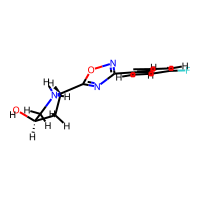

In [3]:
path, df = read_in_conformations(insilico = False, protbound = True)
df.head(1)

# Ro3 and Ro5 compliance

In [4]:
def ro5_and_ro3_compliance(SMILES):
    """Does the molecule in the dataframe 'SMILES' column fulfil the Ro5 or Ro3, respectively? """

    # Generate molecule from SMILES
    mol = Chem.MolFromSmiles(SMILES)
    # If no molecule could be generated, skip the following steps 
    if mol is None: 
        pass

    # Add explicit hydrogen atoms to molecule
    else: 
        molh = Chem.AddHs(mol)

    if molh is None: 
        pass

    else: 

        # Compute Ro5/Ro3-relevant molecular descriptors
        MW              = Descriptors.MolWt(molh)
        HBA             = Lipinski.NumHAcceptors(molh)
        HBD             = Lipinski.NumHDonors(molh)
        LogP            = Descriptors.MolLogP(molh)
        NRB             = Lipinski.NumRotatableBonds(molh)  
        TPSA            = rdMolDescriptors.CalcTPSA(molh)   
        Num_Heavy_Atoms = Lipinski.HeavyAtomCount(molh)    


        # Define the Ro5 conditions 
        Ro5 = [
            MW <= 500, 
            HBA <= 10, 
            HBD <= 5, 
            LogP <= 5,
            NRB <= 10,     # Veber's extension
            TPSA <= 140,   # Veber's extension
            ]

        # If the molecule violates no more than 1 out of the 4 Ro5 conditions, return True
        Ro5_Fulfilled = sum(Ro5) >= (len(Ro5)-1) 

        # Define the Ro3 conditions 
        Ro3 = [
            MW <= 300, 
            HBA <= 3, 
            HBD <= 3, 
            LogP <= 3,
            ]
        
        # If the molecule violates no more than 1 out of the 4 Ro3 conditions, return True.
        Ro3_Fulfilled = sum(Ro3) >= (len(Ro3)-1) 

        # Store the results in a pandas series 
        # Using the name of the variables as the index name

        # pd.Series([SMILES, MW, HBA, HBD, LogP, NRB, TPSA, Num_Heavy_Atoms, Ro5, Ro5_Fulfilled, Ro3, Ro3_Fulfilled],
            # index=['SMILES', 'MW', 'HBA', 'HBD', 'LogP', 'NRB', 'TPSA', 'NHA', 'Ro5', 'Ro5_Fulfilled', 'Ro3', 'Ro3_Fulfilled'])

    return pd.Series({key: value for key, value in vars().items() #if key not in ['Ro5', 'Ro3']
                      })

327


,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,SMILES,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True

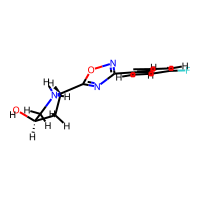
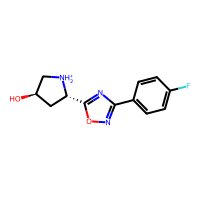
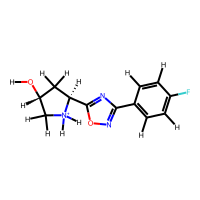

In [5]:
# Apply the function and add to the initial dataframe df
df = pd.concat([df, df["Standardized_SMILES"].apply(ro5_and_ro3_compliance)], ignore_index=False, axis=1, )

# Rename columns 
df = df.rename(columns={'mol': '2D_Mol', 'molh':'2D_Mol_H'})

print(len(df)) 
df.head(1)

# Calculation of Descriptors for Molecular 3D Character
## Independent of Molecular Conformation
### Fraction of sp 3 carbon atoms (Fsp3)
- Introduced by Lovering et al (2009)
- Defined as the number of sp3 hybridized carbons divided by the total number of all carbons in the molecule
- Widely employed, easily interpretable descriptor 
- Major limitation: Only accounts for carbons
- Threshold for molecular three-dimensionality reported in the literature: 
    |                 | Fsp3      |
    |-----------------|-----------|
    | Kombo et al.    | >= 0.42   |
    | Tajabadi et al. | >= 0.45   |

,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,SMILES,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Fsp3_0.42,Fsp3_0.45
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.333333,False,False

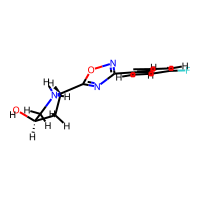
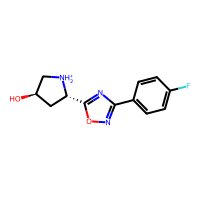
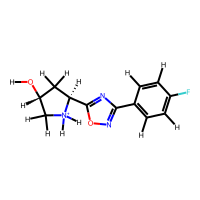

In [6]:
# Compute the Fsp3 
df["Fsp3"] = df["2D_Mol_H"].apply(Lipinski.FractionCSP3)

# Boolean Indicator, indicating if the threshold is passed
df['Fsp3_0.42'] = df['Fsp3'] >= 0.42
df['Fsp3_0.45'] = df['Fsp3'] >= 0.45

df.head(1)

### Fraction of stereogenic carbons (FCstereo)
- Introduced by Lovering et al (2009)
- Defined as the number of stereogenic/chiral carbons divided by the total number of all carbons in the molecule
- Widely employed, easily interpretable descriptor 
- Major limitation: Only accounts for carbons

In [7]:
def calc_FCstereo(molh):
    """
    Calculates the number of stereogenic/chiral carbon atoms in a molecule, 
    the total number of carbon atoms, and the relative measure FCstereo.

    Parameters:
    - mol (RDKit Mol): An RDKit molecule object.

    Returns:
        A tuple containing the numeric descriptors. 

    """
    # Get the number of stereocenters in the molecule
    stereocenters = Chem.FindMolChiralCenters(molh, includeUnassigned=True, useLegacyImplementation=False)

    # Filter the stereocenters list to only include tuples where the atom type is carbon.
    # The length of the filtered list corresponds to the number of stereogenic carbons
    stereogenic_carbons  = len([(atom_num, stereocenter) for atom_num, stereocenter in stereocenters 
                                if molh.GetAtomWithIdx(atom_num).GetSymbol() == 'C'])

    # Total number of carbon atoms in the molecule
    carbon_atoms  = len(molh.GetAtomsMatchingQuery(rdqueries.AtomNumEqualsQueryAtom(6)))

    # Calculate the fraction of stereocenters per carbon atom.
    if carbon_atoms != 0:
        FCstereo = stereogenic_carbons / carbon_atoms
    else: 
        FCstereo = None 
    
    return stereogenic_carbons, carbon_atoms, FCstereo

,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,SMILES,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Fsp3_0.42,Fsp3_0.45,Stereogenic_Carbons,C_Atoms,FCStereo
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.333333,False,False,2,12,0.166667
1,005_D_3,CF,None,D,3,17,12,A,O[C@H](C1)CN[C@@H]1c1nc(-c2nccnc2)n[o]1,"(3R,5S)‐5‐[3‐(pyrazin‐2‐yl)‐1,2,4‐oxadiazol‐5‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=N...,,F005,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=N...,,,234.239,6,2,-1.1043,3,101.54,17,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.400000,False,False,2,10,0.200000

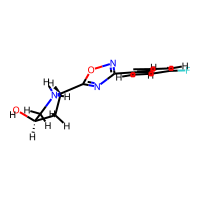
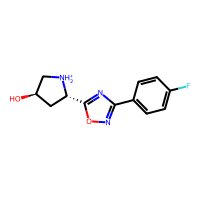
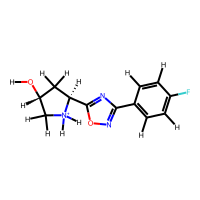
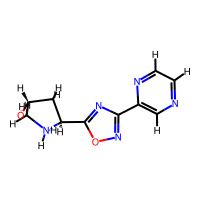
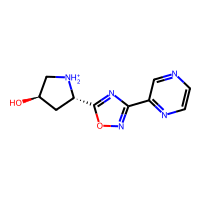
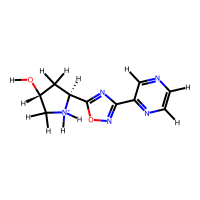

In [8]:
# Apply the function
df["Stereogenic_Carbons"], df["C_Atoms"], df['FCStereo'] = zip(*df["2D_Mol_H"].apply(calc_FCstereo))

df.head(2)

### Spacial score (SPS) and normalized SPS (nSPS)
- Introduced by Krzyzanowski et al. (2023)
- Based on 4 parameters, calculated for each heavy (non-hydrogen) atom in a molecule, summed across the whole structure: 
    - atom hybridization term, 
    - stereoisomeric term (strongly related to FCstereo), 
    - non-aromatic ring term 
    - number of heavy-atom neighbors.
- As the SPS is dependent on molecular size, the authors suggested normalizing the score by dividing by the
total number of heavy atoms. => nSPS
- No threshold for molecular three-dimensionality defined in the literature yet.

In [9]:
class SpacialScore:
    """Class intended for calculating spacial score (SPS) and size-normalized SPS (nSPS) for small organic molecules"""
    def __init__(self, mol):
        self.mol = mol
        self.hyb_score = {}
        self.stereo_score = {}
        self.ring_score = {}
        self.bond_score = {}
        self.chiral_idxs = self.find_stereo_atom_idxs()
        self.doublebonds_stereo = self.find_doublebonds_stereo()
        self.score = self.calculate_spacial_score()
        self.per_atom_score = self.score/Chem.Lipinski.HeavyAtomCount(self.mol)


    def find_stereo_atom_idxs(self, includeUnassigned=True):
        """Finds indices of atoms that are (pseudo)stereo/chiralcentres, in respect to the attached groups (does not account for double bond isomers)"""
        Num_Stereo_centers = Chem.FindMolChiralCenters(self.mol, includeUnassigned=includeUnassigned, includeCIP=False, useLegacyImplementation=False)
        stereo_idxs = [atom_idx for atom_idx, _ in Num_Stereo_centers]
        return stereo_idxs
    

    def find_doublebonds_stereo(self):
        """Finds indices of stereo double bond atoms (E/Z)"""
        db_stereo = {}
        for bond in self.mol.GetBonds():
            if str(bond.GetBondType()) == "DOUBLE":
                db_stereo[(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())] = bond.GetStereo()
        return db_stereo


    def calculate_spacial_score(self):
        """Calculates the total spacial score for a molecule"""
        score = 0
        for atom in self.mol.GetAtoms():
            atom_idx = atom.GetIdx()
            self.hyb_score[atom_idx]    = self._account_for_hybridisation(atom)
            self.stereo_score[atom_idx] = self._account_for_stereo(atom_idx)
            self.ring_score[atom_idx]   = self._account_for_ring(atom)
            self.bond_score[atom_idx]   = self._account_for_neighbours(atom)
            score += self._calculate_score_for_atom(atom_idx)
        return score


    def _calculate_score_for_atom(self, atom_idx):
        """Calculates the total score for a single atom in a molecule"""
        atom_score = self.hyb_score[atom_idx] * self.stereo_score[atom_idx] * self.ring_score[atom_idx] * self.bond_score[atom_idx]
        return atom_score


    def _account_for_hybridisation(self, atom):
        """Calculates the hybridisation score for a single atom in a molecule"""
        hybridisations = {"SP": 1, "SP2": 2, "SP3": 3}
        hyb_type = str(atom.GetHybridization())

        if hyb_type in hybridisations.keys():
            return hybridisations[hyb_type]
        return 4  # h score for any other hybridisation than sp, sp2 or sp3 
    

    def _account_for_stereo(self, atom_idx):
        """Calculates the stereo score for a single atom in a molecule"""
        if atom_idx in self.chiral_idxs:
            return 2
        for bond_atom_idxs, stereo in self.doublebonds_stereo.items():
            if atom_idx in bond_atom_idxs and not(str(stereo).endswith("NONE")):
                return 2
        return 1


    def _account_for_ring(self, atom):
        """Calculates the ring score for a single atom in a molecule"""
        if atom.GetIsAromatic():  # aromatic rings are not promoted 
            return 1
        if atom.IsInRing():
            return 2
        return 1


    def _account_for_neighbours(self, atom):
        """Calculates the neighbour score for a single atom in a molecule
        The second power allows to account for branching in the molecular structure"""
        return (len(atom.GetNeighbors()))**2


def calculate_score_from_smiles(mol, per_atom=False) -> float:
    """ Calculates the spacial score as a total SPS or size-normalized, per-atom nSPS for a molecule.

    Parameters:
    ===========
    smiles: valid SMILES string
    per_atom: flag to denote if the normalized per-atom result (nSPS) should be returned

    Returns:
    ========
    Total or per-atom numeric spacial score for the provided molecule.
    """
    
    if mol is np.nan:
        return np.nan
    sps = SpacialScore(mol)
    if per_atom:
        return sps.per_atom_score
    return sps.score

,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,SMILES,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Fsp3_0.42,Fsp3_0.45,Stereogenic_Carbons,C_Atoms,FCStereo,SPS,nSPS
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.333333,False,False,2,12,0.166667,422,23.444444

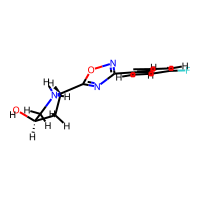
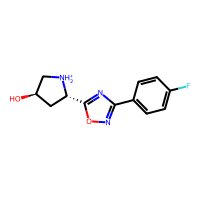
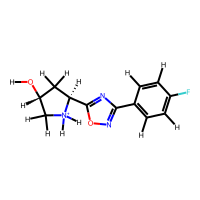

In [10]:
df["SPS"] = df["2D_Mol"].apply(calculate_score_from_smiles)

# Normalize: Divide by the number of heavy atoms 
df[f'nSPS'] = df['SPS'] / df['Num_Heavy_Atoms']

df.head(1)

## Dependent on Molecular Conformation

### Plane of Best Fit (PBF)
- Introduced by Firth et al. (2012)
- Mathematical theoretical range extends from zero to infinity
- In practice, the PBF tends to be < 2 Å for small drug-like molecules
- A higher PBF value corresponds to a higher degree of molecular three-dimensionality
- Threshold proposed by Firth et al. for a dataset of Ro5 compliant molecules: PBF >= 0.6
- Is dependent on the molecular size! => Either compare only similar-sized compounds or normalize, <br>
e.g. by dividing by the number of heavy atoms in the molecule. 

nPBF descriptor value range across all compounds and datasets = 0.0004 -- 0.0832


,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,SMILES,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Fsp3_0.42,Fsp3_0.45,Stereogenic_Carbons,C_Atoms,FCStereo,SPS,nSPS,PBF,PBF_0.6,nPBF,nPBF_0.016
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.333333,False,False,2,12,0.166667,422,23.444444,0.576108,False,0.032006,True

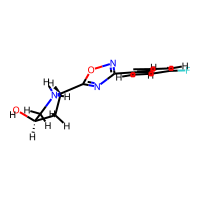
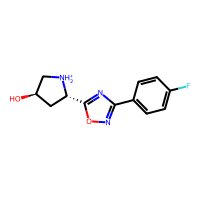
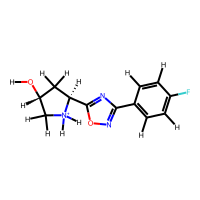

In [11]:
def PBF_score(mol3d):
    """Calculate the plane of best fit (PBF) descriptor """
    try:
        PBF = rdMolDescriptors.CalcPBF(mol3d)
    except:
        return np.nan
    return PBF

# Apply the PBF_score function to the smiles column of the output_df DataFrame
df["PBF"] = df["3D_Mol_H"].apply(PBF_score)

# Boolean Indicator, indicating if the threshold is passed. 
df['PBF_0.6'] = df['PBF'] >= 0.6

# Normalize: Divide by the number of heavy atoms 
df['nPBF'] = df['PBF'] / df['Num_Heavy_Atoms']

print(f"nPBF descriptor value range across all compounds and datasets = {round(df['nPBF'].min(), 4)} -- {round(df['nPBF'].max(), 4)}")

# Boolean Indicator, indicating if the threshold is passed 
df['nPBF_0.016'] = df['nPBF'] >= 0.016

df.head(1)

### Principal moments of inertia (PMIs) 
### Normalized principal moments ratio values (NPRs)
- Introduced by Sauer and Schwarz (2003)

In [12]:
def calc_PMIs_NPRs(mol3d):
    """
    Calculate the Principal moments of inertia (PMI) values as well as 
    their relative measures, the normalized principal moment of inertia ratios (NPR) for a given molecule.

    Parameters:
    mol3d (Chem.Mol): The 3D molecule for which the scores are to be calculated.

    Returns:
    pd.Series: A pandas Series containing the PMI and NPR scores for the given molecule.
    """
    
    # Initialize the the PMI_score series to store the results
    PMI_scores = {}
    PMI_types = ['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2']
    
    # Loop over the PMI types
    for PMI_type in PMI_types:
        # Compute the Descriptor
        try:
            # PMI_scores['PMI1'] = Chem.rdMolDescriptors.CalcPMI1(mol3d) # Example
            PMI_scores[PMI_type] = getattr(Chem.rdMolDescriptors, f'Calc{PMI_type}')(mol3d)
        # If calculation fails, e.g. due to missing conformer, return a NaN value
        except:
            PMI_scores[PMI_type] = np.nan
    
    return pd.Series(PMI_scores, index=PMI_types)

,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,SMILES,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Fsp3_0.42,Fsp3_0.45,Stereogenic_Carbons,C_Atoms,FCStereo,SPS,nSPS,PBF,PBF_0.6,nPBF,nPBF_0.016,PMI1,PMI2,PMI3,NPR1,NPR2
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.333333,False,False,2,12,0.166667,422,23.444444,0.576108,False,0.032006,True,357.796547,3459.277847,3699.400894,0.096717,0.935091

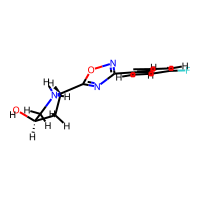
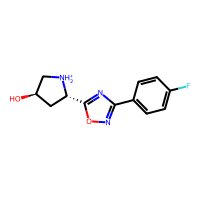
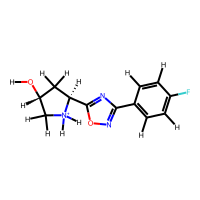

In [13]:
# df[['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2']] = df['3D_Mol'].apply(calc_PMIs_NPRs)
df = pd.concat([df, df["3D_Mol_H"].apply(calc_PMIs_NPRs)], axis=1)
df.head(1)

#### Sum(NPR)
- Values can range from 1.0 to 2.0 <br> 
- A higher value corresponds to a greater deviation of a given molecule’s shape from the rod-disc axis, <br> and thus higher three-dimensionality
- Threshold values for molecular three-dimensionality reported in the literature: <br>
    |                 | Sum(NPR) |
    |-----------------|----------|
    | Firth et al.    | >= 1.07  |
    | Morrison et al. | >= 1.2   |


In [14]:
# Sum up the NPR values
df['Sum_NPR'] = df['NPR1'] + df['NPR2']

# Boolean Indicator, indicating if the threshold is passed
df['Sum_NPR_1.07'] = df['Sum_NPR'] >= 1.07 
df['Sum_NPR_1.2'] = df['Sum_NPR'] >= 1.2

#### Sphericity, rod-likeness and disc-likeness 
as introduced by Wirth et al. (2013)

In [15]:
# df['Sphericity']    = df['NPR1']+ df['NPR2'] - 1
# df['Rod_likeness']  = df['NPR1']- df['NPR2']
# df['Disc_likeness'] = 2- (2 * df['NPR2'])

# Calculation of all 2D RDKit Descriptors 

In [16]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor functions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

# Apply the function and compute all descriptors
df = pd.concat([df, pd.DataFrame([getMolDescriptors(mol) for mol in df['2D_Mol']])], axis=1)

# Delete any redundant columns (with the same column header)
duplicate_cols = df.columns[df.columns.duplicated()]
df = df.loc[:, ~df.columns.duplicated(keep='first')]

# df.head(1)

[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerator
[14:21:44] DEPRECATION WARNING: please use MorganGenerat

## Natural Product (NP) Likeness Score

In [17]:
fscore = npscorer.readNPModel()

def calc_NPlikeness(mol):
    NP_Likeness = npscorer.scoreMol(mol, fscore)
    return NP_Likeness

reading NP model ...
model in


[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerator
[14:21:45] DEPRECATION WARNING: please use MorganGenerat

,Ligand_Instance,Dataset,PDB_ID,Chain,Resi,Num_Resolved_Atoms,Num_H_Atoms_ProtBoundConf,Pocket,SMILES,Name,Num_Not_Resolved_Atoms,ATP_Site,Peripheral,Standardized_SMILES,3D_Mol_H,ID,2D_Mol,2D_Mol_H,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Fsp3_0.42,Fsp3_0.45,Stereogenic_Carbons,C_Atoms,FCStereo,SPS,nSPS,PBF,PBF_0.6,nPBF,nPBF_0.016,PMI1,PMI2,PMI3,NPR1,NPR2,Sum_NPR,Sum_NPR_1.07,Sum_NPR_1.2,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,NP_Likeness
0,001_B_2,CF,None,B,2,18,13,X,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",0,True,True,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,,F001,,,250.253,4,2,0.2448,3,75.76,18,"[True, True, True, True, True, True]",True,"[True, False, True, True]",True,0.333333,False,False,2,12,0.166667,422,23.444444,0.576108,False,0.032006,True,357.796547,3459.277847,3699.400894,0.096717,0.935091,1.031809,False,False,12.799287,12.799287,0.015461,-0.32299,0.800487,250.253,237.149,250.098631,94,0,0.284787,-0.386989,0.386989,0.284787,1.333333,2.111111,2.777778,19.142142,10.169405,2.318699,-1.975495,2.205953,-2.822694,5.532103,-0.680379,2.982762,1.827384,540.510481,12.535169,9.583519,9.583519,8.720347,5.831069,5.831069,4.430538,4.430538,3.080041,3.080041,2.110578,2.110578,-1.79,25520.514803,11.308931,4.47078,2.118818,102.637048,14.946411,18.465944,6.041841,5.824404,5.890724,0.0,0.0,4.390415,4.983979,0.0,5.156663,24.265468,11.984273,0.0,19.336826,0.0,0.0,10.140642,0.0,18.566629,6.544756,35.973413,0.0,11.387856,5.316789,4.390415,0.0,0.0,27.89
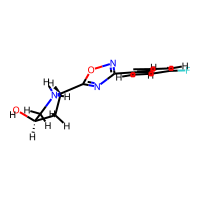
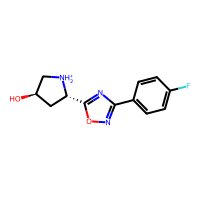
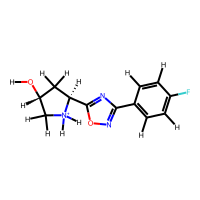

In [18]:
# Apply the function to the data frame
df["NP_Likeness"] = df["2D_Mol"].apply(calc_NPlikeness)

df.head(1)

# Save results to files

In [19]:
def save_dataframe_to_sdf(dataset, filename, molColName, idName):
    """
    Helper function to save a DataFrame  as an SDF file.

    Parameters:
    dataset (DataFrame):  The DataFrame to be saved.
    filename (str):       The path and name of the SDF file.
    molColName (str):     The name of the molecule column.
    idName (str):         The column to serve as the molecule title.
    sdf_cols (list):      List of properties to export.
    """

    sdf_cols = [col for col in dataset.columns if col not in ('SMILES', '2D_Mol')]

    PandasTools.WriteSDF(dataset,                    # Sub-Dataframe to be saved
                         filename,                   # Path and name of .sdf file
                         molColName=molColName,      # Name of the molecule column
                         idName=idName,              # Select a column to serve as molecule title
                         properties=sdf_cols,        # List of properties to export
                         allNumeric=False,           # Automatically include all numeric columns in the output
                         forceV3000=True             # Use the .sdf file V3000 format
                         )
    

def save_dataframe_chunk_to_sdf(df, sdffile_path, molColName = '3D_Mol_H',  idName = 'ID'):
    """
    Save a DataFrame chunk as an SDF file.

    Parameters:
    df (DataFrame):     The DataFrame to be saved.
    sdffile_path (str): The path for the SDF files.
    molColName (str):   The name of the molecule column. Default is '3D_Mol_H'.
    idName (str):       The column to serve as the molecule title. Default is 'ID'.
    """
    
    chunk_size = 999

    # Split the DataFrame into the individual datasets
    for dataset_name in df['Dataset'].unique():

        dataset = df[df['Dataset'] == dataset_name]

        # Split the subset into chunks of max. 999 molecules each
        num_chunks = (len(dataset) + chunk_size - 1) // chunk_size  # Calculate number of chunks

        for i in range(num_chunks):
            chunk = dataset.iloc[i * chunk_size:(i + 1) * chunk_size]

            if len(chunk) < chunk_size:
                filename = os.path.join(sdffile_path, f'All_Descriptor_Values_{dataset_name}.sdf')
            else:
                filename = os.path.join(sdffile_path, f'All_Descriptor_Values_{dataset_name}_Part_{i + 1}.sdf')

            # Save the chunk as an SDF file
            save_dataframe_to_sdf(chunk, filename, molColName, idName)

In [20]:
# Write to excel file
excel_cols = [col for col in df.columns if col not in ('2D_Mol', 'Standardized_Structure')]
df.to_excel(os.path.join(path, 'All_Descriptor_Values.xlsx'),
            index=False, columns = excel_cols)

# Write to .sdf file
save_dataframe_chunk_to_sdf(df, sdffile_path = os.path.join(path, 'sdf_Files'))

# Apply some functions also to the dataset of NPs

In [21]:
# Build path
NPs_path = os.path.join('Analysis', 'NPs')

# Read in data
NPs_df = pd.read_csv(os.path.join(NPs_path, 'NPs_with_CF_FRG_substructure.csv'))

# Drop duplicates
NPs_df = NPs_df.drop_duplicates(subset='COCONUT_SMILES').reset_index(drop=True) 

# Also drop the fragments themselves 
NPs_df = NPs_df[NPs_df['Num_Exit_Atoms'] != 0].reset_index(drop=True)

# Print number of actual, distinct NPs
print(len(NPs_df))

NPs_df = pd.concat([NPs_df, NPs_df["COCONUT_SMILES"].apply(ro5_and_ro3_compliance)], ignore_index=False, axis=1)

NPs_df = NPs_df.rename(columns={'mol': 'COCONUT_2D_Mol', 'molh':'COCONUT_2D_Mol_H'})

NPs_df["Fsp3"] = NPs_df["COCONUT_2D_Mol"].apply(Lipinski.FractionCSP3)
NPs_df["Stereogenic_Carbons"], NPs_df["C_Atoms"], NPs_df['FCStereo'] = zip(*NPs_df["COCONUT_2D_Mol"].apply(calc_FCstereo))
NPs_df["SPS"] = NPs_df["COCONUT_2D_Mol"].apply(calculate_score_from_smiles)
NPs_df[f'nSPS'] = NPs_df['SPS'] / NPs_df['Num_Heavy_Atoms']
NPs_df['NumAromaticRings'] = NPs_df["COCONUT_2D_Mol"].apply(rdMolDescriptors.CalcNumAromaticRings)

NPs_df["NP_Likeness"] = NPs_df["COCONUT_2D_Mol"].apply(calc_NPlikeness)

NPs_df = NPs_df.drop(columns=['COCONUT_2D_Mol', 'COCONUT_2D_Mol_H', 'SMILES', 'CF_FRG', 'CF_SMILES', 'Murcko_SMILES', 'Substructure_SMILES'])

NPs_df.to_excel(os.path.join(NPs_path, 'NPs_Descriptors.xlsx'), index=False)

NPs_df.head(1)

1611


[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerator
[14:21:48] DEPRECATION WARNING: please use MorganGenerat

,COCONUT_SMILES,COCONUT_ID,Exit_Atom_Numbers,Num_Exit_Atoms,Substructure_Exit_Atoms,MW,HBA,HBD,LogP,NRB,TPSA,Num_Heavy_Atoms,Ro5,Ro5_Fulfilled,Ro3,Ro3_Fulfilled,Fsp3,Stereogenic_Carbons,C_Atoms,FCStereo,SPS,nSPS,NumAromaticRings,NP_Likeness
0,O[C@@H]1C[C@@H](C2=NC(C3=CN=CC=N3)=NO2)N(CC2=C...,CNP0410447.1,[3],1,<rdkit.Chem.rdchem.Mol object at 0x7729d93d2d40>,323.356,7,1,1.8345,5,88.17,24,"[True, True, True, True, True, True]",True,"[False, False, True, True]",False,0.294118,2,17,0.117647,509,21.208333,3,-1.479057
